<h1 style="text-align:center">
<u>Quantitative Trading Strategies</u>
</h1>

In [2]:
import os
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
import polars as pl 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import yfinance as yf
import backtrader as bt

import torch as th
import tensorflow as tf
import keras as kr
import sklearn as sk
import statsmodels as sm

## Data Loading & Exploring

In [87]:
biggestCaps = pd.read_csv('data/raw/biggestCaps.csv')
tickers = biggestCaps['Symbol'].tolist()[:1000]

In [94]:
# Download data for yfinance and save it as a parquet file

for ticker in tqdm(tickers):
    data = yf.download(ticker, start='2010-01-01', end='2025-01-01', progress=False)
    data.to_parquet(f'data/raw/{ticker}.parquet')

  5%|▍         | 46/1000 [00:24<08:13,  1.93it/s]
1 Failed download:
['IHC.AE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
 18%|█▊        | 185/1000 [01:18<03:50,  3.54it/s]
1 Failed download:
['TAQA.AE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
 28%|██▊       | 277/1000 [02:04<11:50,  1.02it/s]
1 Failed download:
['ADNOCGAS.AE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
 31%|███       | 308/1000 [02:22<04:09,  2.78it/s]
1 Failed download:
['CNQ']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2010-01-01 -> 2025-01-01)')
 48%|████▊     | 482/1000 [03:39<02:52,  3.00it/s]
1 Failed download:
['FAB.AE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
 53%|█████▎    | 533/1000 [04:01<02:07,  3.67it/s]
1 Failed download:
['EAND.AE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
 61%|██████    | 606/1000 [04:39<03:30,  1.88it/s]
1 Failed 

In [95]:
data = pd.read_parquet('data/raw/AAPL.parquet')

data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.447412,6.462174,6.398306,6.429939,493729600
2010-01-05,6.458557,6.495010,6.424514,6.465185,601904800
2010-01-06,6.355826,6.484166,6.349198,6.458558,552160000
2010-01-07,6.344076,6.386857,6.297982,6.379325,477131200
2010-01-08,6.386255,6.386858,6.298286,6.335642,447610800


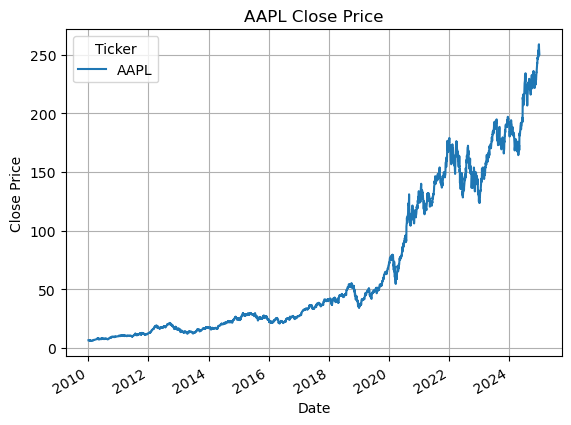

In [96]:
data['Close'].plot(xlabel='Date', ylabel='Close Price', title='AAPL Close Price', grid=True)
plt.show()

In [163]:
# For each stock, calculate the daily log returns and save it as a parquet file

for ticker in tqdm(tickers):
    data = pd.read_parquet(f'data/raw/{ticker}.parquet')
    data['log_return'] = np.log(data['Close']).diff()
    data.to_parquet(f'data/processed/{ticker}.parquet')

 74%|███████▎  | 737/1000 [00:09<00:03, 77.34it/s]/opt/anaconda3/envs/algo-trading/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1000/1000 [00:12<00:00, 77.28it/s]


## Price Prediction

#### - **Linear Regression**

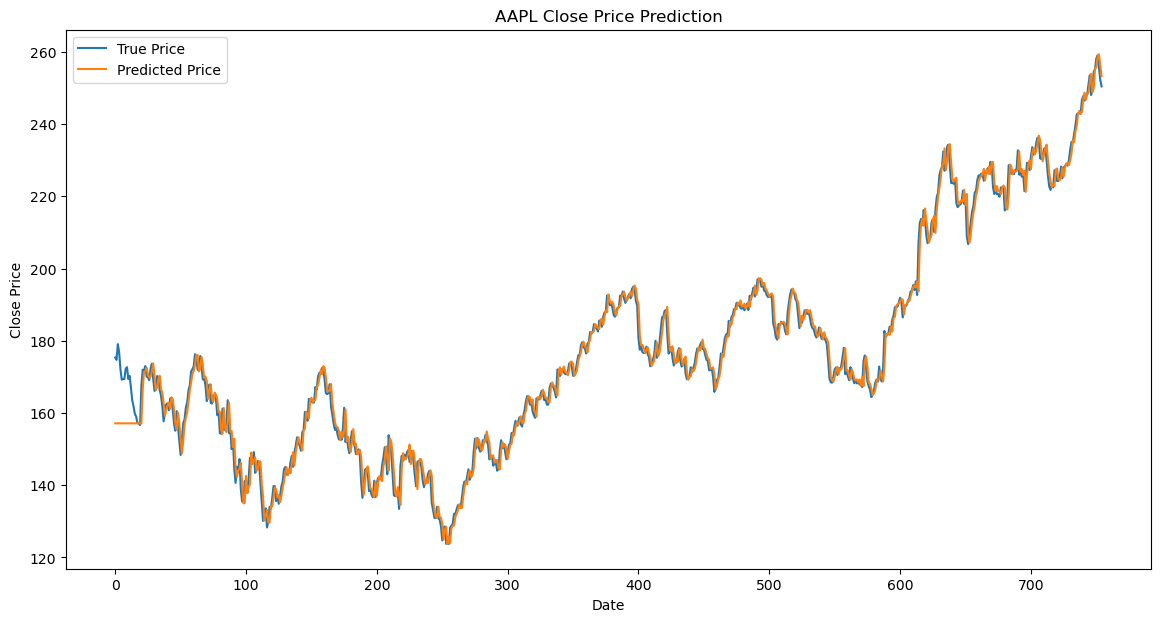

Mean Squared Error: 8.442908016002628


In [132]:
# Split the data into training and testing sets

train_data = data['Close'][:int(0.8*len(data))].to_numpy()
test_data = data['Close'][int(0.8*len(data)):].to_numpy()

# Create the features and target variables

def create_features(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X)[:,:,0], np.array(y)

window_size = 20

X_train, y_train = create_features(train_data, window_size)
X_test, y_test = create_features(test_data, window_size)

# Create and train the linear regression model

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions

predictions = model.predict(X_test).flatten()

# Plot the predictions

plt.figure(figsize=(14,7))
plt.plot(test_data, label='True Price')
plt.plot(np.concatenate((predictions[0]*np.ones(window_size), predictions)), label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL Close Price Prediction')
plt.legend()
plt.show()

# Model Evaluation

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_data[window_size:], predictions)
print(f'Mean Squared Error: {mse}')

#### - **SMAs & EMAs**

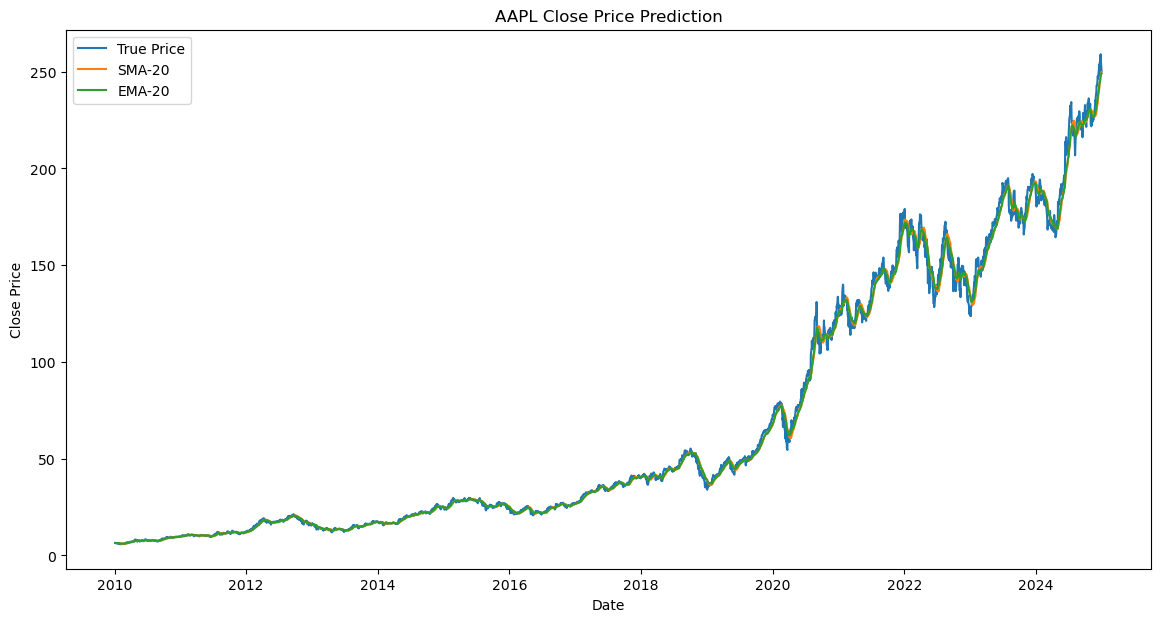

SMA Mean Squared Error: 14.82106716956091
EMA Mean Squared Error: 10.955387413438935


In [149]:
# SMA and EMA Prediction

def sma(data, window_size):
    return data.rolling(window_size).mean()

def ema(data, days):
    return data.ewm(span=days, adjust=False).mean()

sma_predictions = sma(data['Close'], window_size).to_numpy().flatten()

ema_predictions = ema(data['Close'], window_size).to_numpy().flatten()

# Plot the predictions
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='True Price')
plt.plot(data.index, sma_predictions, label=f'SMA-{window_size}')
plt.plot(data.index, ema_predictions, label=f'EMA-{window_size}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL Close Price Prediction')
plt.legend()
plt.show()

# Model Evaluation

sma_mse = mean_squared_error(data['Close'][window_size:], sma_predictions[window_size:])
ema_mse = mean_squared_error(data['Close'][window_size:], ema_predictions[window_size:])

print(f'SMA Mean Squared Error: {sma_mse}')
print(f'EMA Mean Squared Error: {ema_mse}')


#### - **ARIMA**

/opt/anaconda3/envs/algo-trading/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/algo-trading/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/algo-trading/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


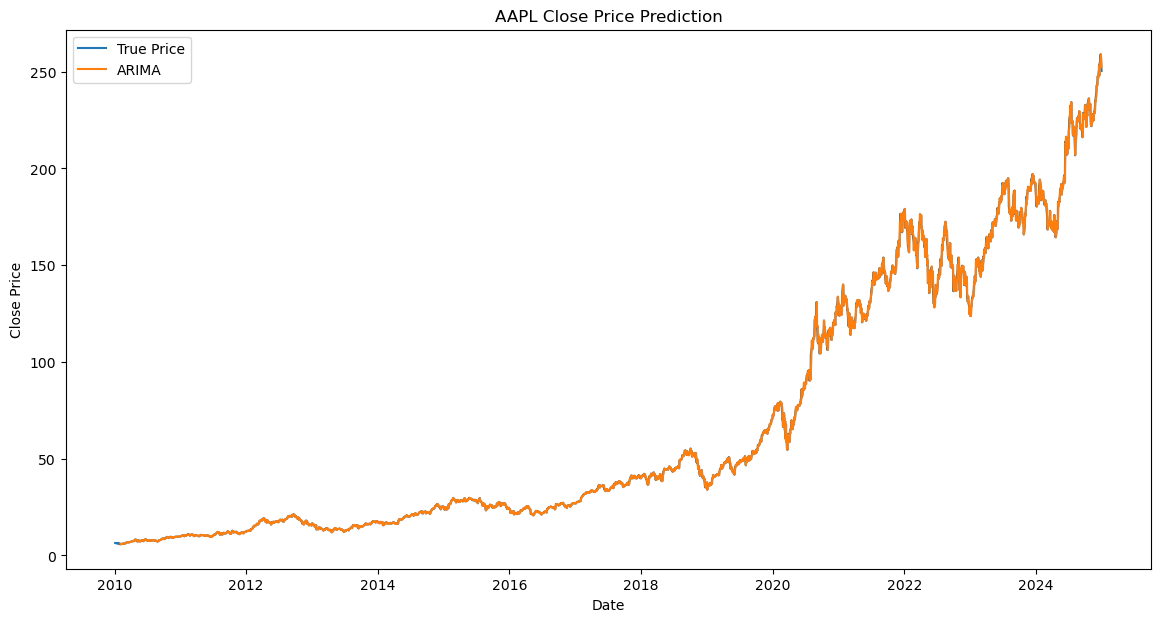

ARIMA Mean Squared Error: 2.5144562459419775


In [152]:
# Arima Prediction

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Close'], order=(5,1,0))

model_fit = model.fit()

arima_predictions = model_fit.predict(start=window_size, end=len(data)-1)

# Plot the predictions

plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='True Price')
plt.plot(data.index[window_size:], arima_predictions, label='ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL Close Price Prediction')
plt.legend()
plt.show()

# Model Evaluation

arima_mse = mean_squared_error(data['Close'][window_size:], arima_predictions)
print(f'ARIMA Mean Squared Error: {arima_mse}')

#### - **LSTM**

In [161]:
# LSTM Prediction

from keras.models import Sequential
from keras.layers import LSTM, Dense

X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=10, batch_size=32)

lstm_predictions = model.predict(X_test).flatten()

Epoch 1/10


/opt/anaconda3/envs/algo-trading/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 475.6628
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.7153
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.6005
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 7.5099
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2205
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.9152
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6247
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6329
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3076
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7799
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


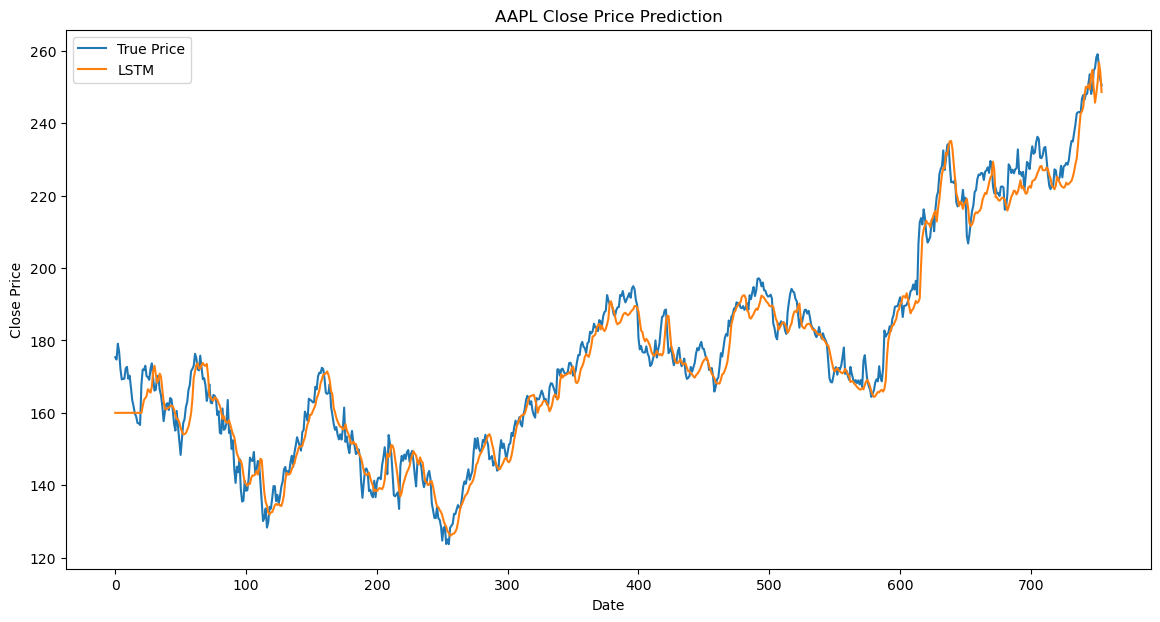

LSTM Mean Squared Error: 23.36319310092787


In [162]:
# Plot the predictions

plt.figure(figsize=(14,7))
plt.plot(test_data, label='True Price')
plt.plot(np.concatenate((lstm_predictions[0]*np.ones(window_size), lstm_predictions)), label='LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('AAPL Close Price Prediction')
plt.legend()
plt.show()

# Model Evaluation

lstm_mse = mean_squared_error(test_data[window_size:], lstm_predictions)
print(f'LSTM Mean Squared Error: {lstm_mse}')

### Trading Strategies

In [191]:
# Create a DataFrame containing all Returns

returns = []

for ticker in tqdm(tickers):
    data = pd.read_parquet(f'data/processed/{ticker}.parquet')
    returns.append(data['log_return'])
returns = pd.concat(returns, axis=1)
returns.columns = tickers
returns.to_parquet('data/processed/returns.parquet')

100%|██████████| 1000/1000 [00:04<00:00, 238.92it/s]


In [4]:
returns = pd.read_parquet('data/processed/returns.parquet')
returns.head()

,AAPL,NVDA,MSFT,AMZN,GOOG,META,2222.SR,TSLA,TSM,AVGO,...,EC,KEY,SMCI,TEVA,6594.T,EIX,LUMI.TA,TATASTEEL.NS,STLD,PST.MI
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.007335,NaN,NaN,NaN
2010-01-05,0.001727,0.014497,0.000323,0.005883,-0.004413,NaN,NaN,NaN,-0.004327,0.007396,...,-0.000803,0.037989,-0.021940,-0.014268,-0.002315,-0.008956,0.010624,0.023932,-0.006032,NaN
2010-01-06,-0.016034,0.006376,-0.006156,-0.018282,-0.025532,NaN,NaN,NaN,-0.003475,0.007864,...,0.004810,-0.006503,0.019333,0.002451,0.005777,0.012401,-0.010062,-0.010921,0.070093,NaN


In [5]:
# Train-Test Split

train_data = returns.iloc[:int(0.8*len(returns))]
test_data = returns.iloc[int(0.8*len(returns)):]

# Backward fill missing values and Drop columns with only missing values

train_data = train_data.bfill()
test_data = test_data.bfill()

filter_na = train_data.isna().sum(axis=0) == 0

train_data = train_data.loc[:, filter_na]
test_data = test_data.loc[:, filter_na]

#### - **Pairs Trading**

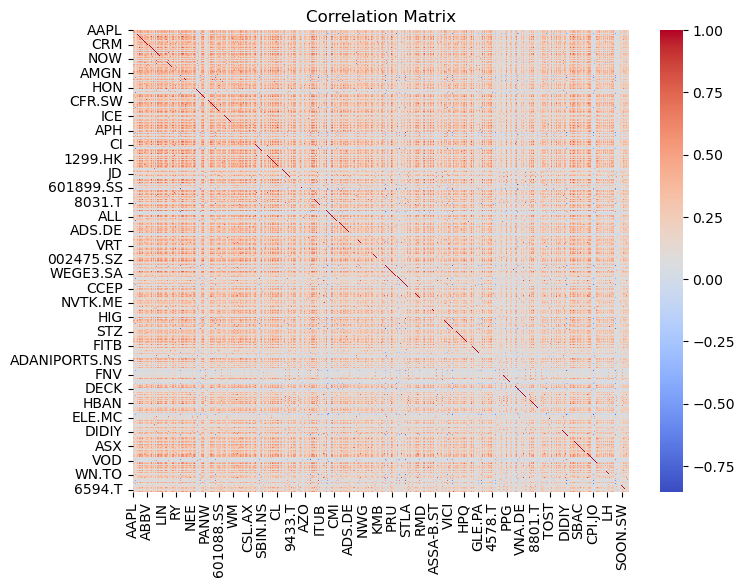

In [6]:
# Compute Correlation Matrix

correlation_matrix = train_data.corr()

# Plot the Correlation Matrix

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [7]:
# Keep only the top 10 correlated pairs of stocks

correlation_matrix = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool))

top_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().head(10)

top_pairs  

GDDY       SHOP       0.968840
1150.SR    1120.SR    0.964394
6178.T     7182.T     0.926365
601211.SS  SHOP       0.917405
7182.T     TEAM       0.915106
BBD        ITUB       0.912469
EQR        AVB        0.909460
BBVA       SAN        0.909288
PRU        MET        0.905428
NBK.KW     KFH.KW     0.902789
dtype: float64

In [8]:
# Test for Cointegration
from statsmodels.tsa.stattools import coint

cointegrated_pairs = []

for pair in tqdm(top_pairs.index):
    pvalue = coint(train_data[pair[0]], train_data[pair[1]])[1]
    if pvalue < 0.05:
        cointegrated_pairs.append(pair)

cointegrated_pairs

100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


[('GDDY', 'SHOP'),
 ('1150.SR', '1120.SR'),
 ('6178.T', '7182.T'),
 ('601211.SS', 'SHOP'),
 ('7182.T', 'TEAM'),
 ('BBD', 'ITUB'),
 ('EQR', 'AVB'),
 ('BBVA', 'SAN'),
 ('PRU', 'MET'),
 ('NBK.KW', 'KFH.KW')]

In [9]:
# Determine Hedge Ratios

hedge_ratios = []

for pair in tqdm(cointegrated_pairs):
    X = sm.tools.add_constant(train_data[pair[1]])
    model = sm.regression.linear_model.OLS(train_data[pair[0]], X)
    model = model.fit()
    hedge_ratios.append(model.params[pair[1]])

hedge_ratios

100%|██████████| 10/10 [00:00<00:00, 216.95it/s]


[np.float64(0.6310700047662251),
 np.float64(0.5385393326081235),
 np.float64(0.5818244710837922),
 np.float64(0.22822475038059736),
 np.float64(0.20965041924222835),
 np.float64(0.9816423691968315),
 np.float64(0.9348050136385695),
 np.float64(0.9471228241885448),
 np.float64(0.9304161013767601),
 np.float64(0.7376385103118219)]

/var/folders/5j/w6vdlj1n4fq45bh11q5mwhkw0000gn/T/ipykernel_52165/3690746956.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = spread[spread != spread[0]]


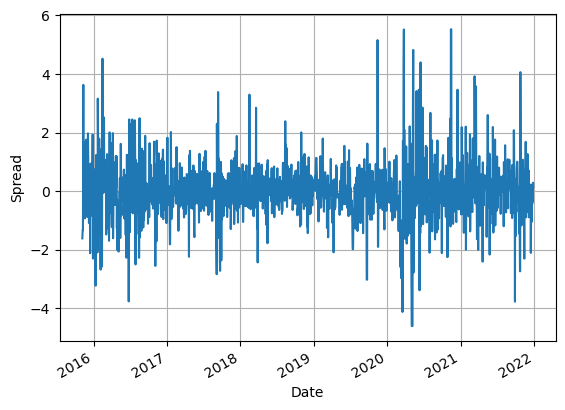

In [10]:
# Compute the Spread (Standardized ie Z Score) 

spreads = []

for i, pair in enumerate(cointegrated_pairs):
    spread = train_data[pair[0]] - hedge_ratios[i]*train_data[pair[1]]
    spread = spread[spread != spread[0]]
    # Z score
    spread = (spread - spread.mean())/spread.std()
    spreads.append(spread)
spreads = pd.concat(spreads, axis=1)
spreads.columns = cointegrated_pairs

spreads[cointegrated_pairs[2]].plot(xlabel='Date', ylabel='Spread', grid=True)
plt.show()    

In [61]:
def pairs_trading_strategy(closeA: pd.Series, closeB: pd.Series,
                           entry_threshold: float, exit_threshold: float,
                           spread_type: str) -> tuple:
    
    # Filter NA 
    filter_na = closeA.notna() & closeB.notna()
    closeA = closeA[filter_na]
    closeB = closeB[filter_na]

    # Compute the returns
    retA = closeA.pct_change()
    retB = closeB.pct_change()

    # Compute the spread
    X = sm.tools.add_constant(closeB)
    model = sm.regression.linear_model.OLS(closeA, X)
    model = model.fit()
    hedge_ratio = model.params.iloc[1]

    # Compute the spread
    if spread_type == 'zscore':
        spread = closeA - hedge_ratio*closeB
        spread = (spread - spread.rolling(20).mean())/spread.rolling(20).std()
    elif spread_type == 'ratio':
        spread = closeA/closeB
    elif spread_type == 'log-difference':
        spread = np.log(closeA) - np.log(closeB)
    else:
        raise ValueError('Invalid spread type')

    # Compute the longs, shorts and exits
    longs = []
    shorts = []
    exits = []

    for i in range(1, len(spread)):
        if spread.iloc[i] > entry_threshold and spread.iloc[i-1] < entry_threshold:
            shorts.append(i)
        elif spread.iloc[i] < -entry_threshold and spread.iloc[i-1] > -entry_threshold:
            longs.append(i)
        elif abs(spread.iloc[i]) < exit_threshold and abs(spread.iloc[i-1]) > exit_threshold:
            exits.append(i)

    return longs, shorts, exits, spread


In [62]:
def backtest_pairs_trading(closeA: pd.Series, closeB: pd.Series,
                           longs: list, shorts: list, exits: list,
                           hedge_ratio: float, init_cash: int = 1000, lot_size: float = 1.0) -> pd.DataFrame:
    
    cash = init_cash
    positionA = 0
    positionB = 0
    portfolio_value = []

    for i in range(len(closeA)):
        if i in longs:
            positionA = lot_size
            positionB = -lot_size*hedge_ratio
            cash -= closeA.iloc[i]
            cash += hedge_ratio*closeB.iloc[i]
        elif i in shorts:
            positionA = -lot_size
            positionB = lot_size*hedge_ratio
            cash += closeA.iloc[i]
            cash -= hedge_ratio*closeB.iloc[i]
        elif i in exits and (positionA != 0 or positionB != 0):
            cash += positionA*closeA.iloc[i]
            cash += positionB*closeB.iloc[i]
            positionA = 0
            positionB = 0
        portfolio_value.append(cash + positionA*closeA.iloc[i] + positionB*closeB.iloc[i])
    
    portfolio_value = pd.Series(portfolio_value, index=closeA.index)

    return portfolio_value

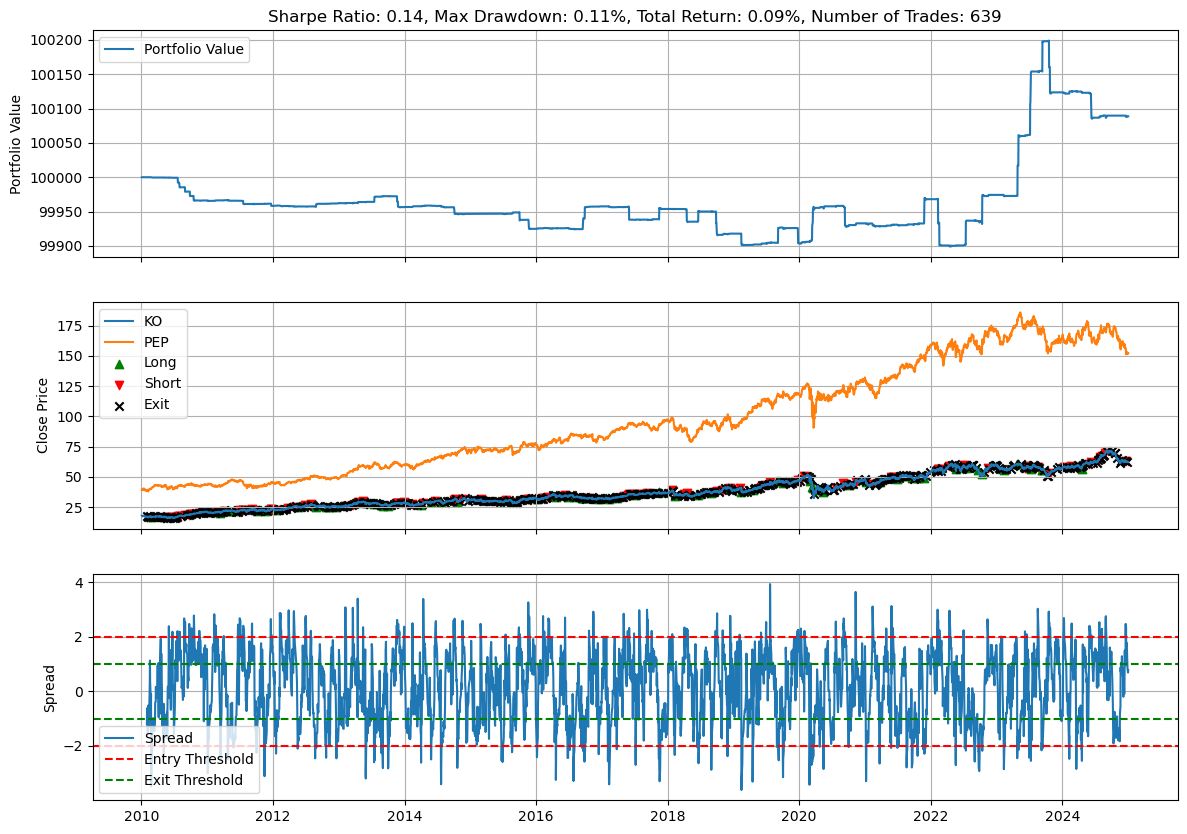

In [66]:
pair = ('KO', 'PEP') #cointegrated_pairs[7]
closeA = pd.read_parquet(f'data/processed/{pair[0]}.parquet')['Close']
closeB = pd.read_parquet(f'data/processed/{pair[1]}.parquet')['Close']

entry_threshold = 2
exit_threshold = 1

longs, shorts, exits, spread = pairs_trading_strategy(closeA, closeB, 
                                                      entry_threshold, exit_threshold, 
                                                      'zscore')
portfolio_value = backtest_pairs_trading(closeA, closeB, 
                                         longs, shorts, exits, 
                                         hedge_ratios[2], init_cash=100_000, lot_size=1)

# Compute Statistics
def compute_statistics(portfolio_value: pd.Series) -> dict:
    returns = portfolio_value.pct_change()
    sharpe_ratio = np.sqrt(252)*returns.mean()/returns.std()
    max_drawdown = (portfolio_value.cummax() - portfolio_value).max()/portfolio_value.iloc[0]
    total_return = (portfolio_value.iloc[-1] - portfolio_value.iloc[0])/portfolio_value.iloc[0]
    return {'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown, 'Total Return': total_return}

statistics = compute_statistics(portfolio_value)
sharpe = statistics['Sharpe Ratio']
drawdown = 100*statistics['Max Drawdown']
total_return = 100*statistics['Total Return']
nb_trades = len(longs) + len(shorts) + len(exits)

# Plot PnL and Entries/Exits

fig, ax = plt.subplots(3, 1, figsize=(14,10), sharex=True)

ax[0].plot(portfolio_value, label='Portfolio Value')
ax[0].set_ylabel('Portfolio Value')
ax[0].grid(True)
ax[0].legend()
ax[0].set_title(f'Sharpe Ratio: {sharpe:.2f}, Max Drawdown: {drawdown:.2f}%, Total Return: {total_return:.2f}%, Number of Trades: {nb_trades}')

ax[1].plot(closeA, label=pair[0])
ax[1].plot(closeB, label=pair[1])
ax[1].scatter(closeA.index[longs], closeA.iloc[longs], marker='^', color='g', label='Long')
ax[1].scatter(closeA.index[shorts], closeA.iloc[shorts], marker='v', color='r', label='Short')
ax[1].scatter(closeA.index[exits], closeA.iloc[exits], marker='x', color='k', label='Exit')
ax[1].set_ylabel('Close Price')
ax[1].grid(True)
ax[1].legend()

ax[2].plot(spread, label='Spread')
ax[2].axhline(entry_threshold, color='r', linestyle='--', label='Entry Threshold')
ax[2].axhline(-entry_threshold, color='r', linestyle='--')
ax[2].axhline(exit_threshold, color='g', linestyle='--', label='Exit Threshold')
ax[2].axhline(-exit_threshold, color='g', linestyle='--')
ax[2].set_ylabel('Spread')
ax[2].grid(True)
ax[2].legend()

plt.show()